In [1]:
%load_ext autoreload
%autoreload 2

import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from timeseries_cross_validation.custom_time_series_split import CustomTimeSeriesSplit

## Generate some data

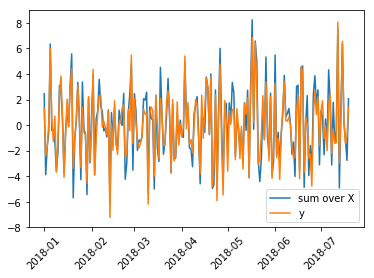

In [2]:
number_of_data_points = 200
number_of_features = 10
date_index = pd.date_range(dt.datetime(2018,1,1), 
                           periods=number_of_data_points, 
                           freq='D')
x = pd.DataFrame(np.random.randn(number_of_data_points, number_of_features), 
                 index=date_index)
y = x.sum(axis=1)*.86+np.random.randn(number_of_data_points)

fig, ax = plt.subplots(1, 1)
ax.plot(x.sum(axis=1), label='sum over X')
ax.plot(y, label='y')
ax.legend()
plt.xticks(rotation=45);

## Specify the sizes of train and test set and initialize the cross validators

In [3]:
outer_train_set_size = 28
outer_test_set_size = 7

inner_train_set_size = 14
inner_test_set_size = 7

outer_loop_splitter = CustomTimeSeriesSplit(
    train_set_size=outer_train_set_size,
    test_set_size=outer_test_set_size)

inner_loop_splitter = CustomTimeSeriesSplit(
    train_set_size=inner_train_set_size,
    test_set_size=inner_test_set_size)

## Initialize algorithms: pipeline + parameter grid

In [4]:
# Initialize models
model_1 = SVR()
model_2 = ElasticNet()

# Initialize pipelines
pipeline_1 = Pipeline([('scaling', StandardScaler()),
                       ('model', model_1)])
pipeline_2 = Pipeline([('scaling', StandardScaler()),
                       ('model', model_2)])

# Initialize hyperparameter grids
param_grid_1 = [{'model__kernel': ['rbf'],
                 'model__C': np.power(10., np.arange(-4, 4)),
                 'model__gamma': np.power(10., np.arange(-5, 0))},
                {'model__kernel': ['linear'],
                 'model__C': np.power(10., np.arange(-4, 4))}]
param_grid_2 = [{'model__l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
                 'model__alpha': [.1, .5, 1, 10, 100]}]

# Make a DataFrame to save all algorithms and include columns to save the results
algorithms = {
        'param_grid': [param_grid_1, param_grid_2],                                            
        'pipeline': [pipeline_1, pipeline_2],
    }
algorithm_names = ['SVR', 'ElasticNet']
algorithms_and_results = pd.DataFrame(algorithms, index=algorithm_names)
for column in ['scores_cv_inner', 'scores_cv_outer']:
    algorithms_and_results[column] = [[] for _ in range(len(algorithm_names))]
algorithms_and_results

,param_grid,pipeline,scores_cv_inner,scores_cv_outer
SVR,"[{'model__kernel': ['rbf'], 'model__C': [0.000...","Pipeline(memory=None,\n steps=[('scaling',...",[],[]
ElasticNet,"[{'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95...","Pipeline(memory=None,\n steps=[('scaling',...",[],[]


## Run the nested cross validation and save the results

In [5]:
# The outer loop for algorithm selection and performance estimation
for outer_train_idx, outer_test_idx in outer_loop_splitter.split(x, y):
    x_train = x.iloc[outer_train_idx]
    y_train = y.iloc[outer_train_idx]
    x_test = x.iloc[outer_test_idx]
    y_test = y.iloc[outer_test_idx]

    # The grid search estimators need to be rebuild each outer fold, because the inner loop
    # cross validation can only be defined given the train set from the outer loop.
    grid_search_cv_estimators = {}
    for (name, param_grid, pipeline) in algorithms_and_results[['param_grid', 'pipeline']].itertuples():
        
        # The inner loop for hyperparameter tuning
        grid_search_cv_estimator = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='r2',
            cv=inner_loop_splitter.split(x_train, y_train),
            n_jobs=4,
            refit=True)
        grid_search_cv_estimator.fit(x_train, y_train)

        outer_score = grid_search_cv_estimator.score(x_test, y_test)
        algorithms_and_results.loc[name, 'scores_cv_inner'].append(grid_search_cv_estimator.best_score_)
        algorithms_and_results.loc[name, 'scores_cv_outer'].append(outer_score)
algorithms_and_results

,param_grid,pipeline,scores_cv_inner,scores_cv_outer
SVR,"[{'model__kernel': ['rbf'], 'model__C': [0.000...","Pipeline(memory=None,\n steps=[('scaling',...","[0.8925873611848526, 0.8037521093102511, 0.800...","[0.7585295854668671, 0.8662412503302521, 0.697..."
ElasticNet,"[{'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95...","Pipeline(memory=None,\n steps=[('scaling',...","[0.8081674995045428, 0.7862186128930835, 0.796...","[0.7777819837512326, 0.810507887851246, 0.4635..."


## Combine the results

In [6]:
for agg_function in [np.mean, np.median, np.std]:
    for column in ['scores_cv_outer', 'scores_cv_inner']:
        aggregation_dict = {column + '_' + agg_function.__name__: lambda df: df[column].map(agg_function)}
        algorithms_and_results = algorithms_and_results.assign(**aggregation_dict)
algorithms_and_results.T

,SVR,ElasticNet
param_grid,"[{'model__kernel': ['rbf'], 'model__C': [0.000...","[{'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95..."
pipeline,"Pipeline(memory=None,\n steps=[('scaling',...","Pipeline(memory=None,\n steps=[('scaling',..."
scores_cv_inner,"[0.8925873611848526, 0.8037521093102511, 0.800...","[0.8081674995045428, 0.7862186128930835, 0.796..."
scores_cv_outer,"[0.7585295854668671, 0.8662412503302521, 0.697...","[0.7777819837512326, 0.810507887851246, 0.4635..."
scores_cv_outer_mean,0.611748,0.666742
scores_cv_inner_mean,0.647371,0.597446
scores_cv_outer_median,0.736947,0.7245
scores_cv_inner_median,0.704251,0.632803
scores_cv_outer_std,0.381995,0.211859
scores_cv_inner_std,0.180002,0.196756


## Select the best algorithm on metric of choice (here mean outer score)

In [7]:
best_algorithm_name = algorithms_and_results['scores_cv_outer_mean'].idxmax()
best_pipeline = algorithms_and_results.loc[best_algorithm_name, 'pipeline']
best_param_grid = algorithms_and_results.loc[best_algorithm_name, 'param_grid']
print(f'Choose best estimater: {best_algorithm_name}')

Choose best estimater: ElasticNet


## Expected score

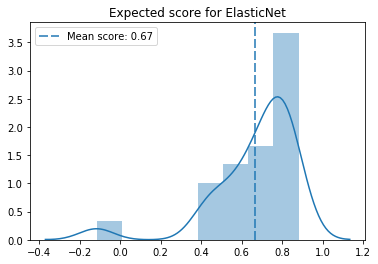

In [8]:
scores, mean_score = algorithms_and_results.loc[best_algorithm_name, ['scores_cv_outer', 'scores_cv_outer_mean']]
ax = sns.distplot(scores)
ax.set_title(f'Expected score for {best_algorithm_name}')
ax.axvline(mean_score, dashes=[6, 2], label=f'Mean score: {round(mean_score,2)}')
ax.legend();

## Search for final hyperparameters on most recent 'outer train set size' data points

In [9]:
x_most_recent = x.iloc[-outer_train_set_size:]
y_most_recent = y.iloc[-outer_train_set_size:]
    
grid_search_cv_estimator = GridSearchCV(
    estimator=best_pipeline,
    param_grid=best_param_grid,
    scoring='r2',
    cv=inner_loop_splitter.split(x_most_recent, y_most_recent),
    n_jobs=4,
    refit=True)
grid_search_cv_estimator.fit(x_most_recent, y_most_recent)
print(f'Final hyperparameters: {grid_search_cv_estimator.best_params_}')

Final hyperparameters: {'model__alpha': 0.1, 'model__l1_ratio': 0.1}
